# CNN - Neural nets -NOTE THERE IS AN ERROR WITH FOLDER LENGTH ITS repeatign!!! its not abcde, have a look :)

## Extracting Testing and training Data

We now define the strucutre of the model, and save the strucutre of the model

In [1]:
## For image recognition
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

##For image analysis
from skimage.io import imread as mainImageRead
from skimage.transform import resize
from scipy.misc import imread, imresize, imsave
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.transform import resize
import skimage.segmentation as segment
from skimage.measure import regionprops
from scipy.ndimage.filters import gaussian_filter
import skimage as skimage
from sklearn.model_selection import train_test_split


##Library for extracting all images in a directory
import glob
import re
import os


class Extract_Letters:
    def extractFile(self, filename):
        image = imread(filename, 1)

        # apply threshold in order to make the image binary
        bw = (image > 120).astype(np.float)

        # remove artifacts connected to image border
        cleared = bw.copy()
        cleared = gaussian_filter(cleared, (2,1))
        cleared = cleared < 1
        segment.clear_border(cleared)


        # label image regions
        label_image = label(cleared, neighbors=4)
        borders = np.logical_xor(bw, cleared)
        label_image[borders] = -1
        
        letters = list()
        order = list()

        for region in regionprops(label_image):
            minr, minc, maxr, maxc = region.bbox
            # skip small images
#             if region.area > 40:
            if region.area > 80:##175 MAKES IT IDEAL FOR DATA EXTRACTION!
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                order.append(region.bbox)

        # sort the detected characters left->right, top->bottom
        lines = list()
        first_in_line = ''
        counter = 0

        # worst case scenario there can be 1 character per line
        for x in range(len(order)):
            lines.append([])

        for character in order:
            if first_in_line == '':
                first_in_line = character
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
                lines[counter].append(character)
            elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
                first_in_line = character
                counter += 1
                lines[counter].append(character)

        for x in range(len(lines)):
            lines[x].sort(key=lambda tup: tup[1])

        final = list()
        prev_tr = 0
        prev_line_br = 0

        for i in range(len(lines)):
            for j in range(len(lines[i])):
                tl_2 = lines[i][j][1]
                bl_2 = lines[i][j][0]
                if tl_2 > prev_tr and bl_2 > prev_line_br:
                    tl, tr, bl, br = lines[i][j]
                    letter_raw = bw[tl:bl, tr:br]
                    letter_norm = resize(letter_raw, (200, 200))
                    final.append(letter_norm)
                    prev_tr = lines[i][j][3]
                if j == (len(lines[i]) - 1):
                    prev_line_br = lines[i][j][2]
            prev_tr = 0
            tl_2 = 0
            ##print ('Characters recognized: ' + str(len(final)))
        print(f"Totally recognised {len(final)} characters")
        return final
    
    def __init__(self):
        print("Extracting characters...")


        
        
trainingSave = "ocr/beingTrained/"
trainingDirectory = "ocr/training/"

trainingFileNames = {}
trainingTarget =[]
trainingPicture =[]

nonCorrectedNames = glob.glob(f"{trainingDirectory}*")
counter = 0
extract = Extract_Letters()
for x in range(len(nonCorrectedNames)):
    currentUserName = nonCorrectedNames[x][len(trainingDirectory):]
    imagesDirectory = glob.glob(f"{nonCorrectedNames[x]}/*.png")
    for imageLocation in imagesDirectory:
        if not os.path.exists(trainingSave+currentUserName):
            os.makedirs(trainingSave+currentUserName)
        extractedSignature=extract.extractFile(imageLocation)
        for signature in extractedSignature:
            imsave(f"{trainingSave}{currentUserName}/{counter}.png", signature)
            ##Extract the image
            img = mainImageRead(f"{trainingSave}{currentUserName}/{counter}.png",as_grey=True)
            arr = np.asarray(img)
            arr=arr.flatten()
            ##Add extracted image
            trainingPicture.append(np.asarray(arr))
            trainingTarget.append(x)
            trainingFileNames[x] = currentUserName
            
            counter=counter+1
        

trainingTarget = np.asarray(trainingTarget)
trainingPicture = np.asarray(trainingPicture)

print(trainingFileNames)
print(trainingTarget.shape)
print(trainingPicture.shape)


target_train, target_test, image_train, image_test = train_test_split(trainingTarget, trainingPicture, test_size=0.33, random_state=42)


Extracting characters...


/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Totally recognised 127 characters


/home/jeeson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/jeeson/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Totally recognised 20 characters
Totally recognised 65 characters
Totally recognised 45 characters
Totally recognised 154 characters
Totally recognised 124 characters
{0: 'user3', 1: 'user1', 2: 'user4', 3: 'user2'}
(535,)
(535, 40000)


In [2]:
## Import the appropraite libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np


imageDimension=int(len(image_train[0]))
imageXDimension=int(np.sqrt(imageDimension))
sizeOfOutputLayer=len(trainingFileNames.keys())
print(imageXDimension,imageDimension,sizeOfOutputLayer)

# imageDimension=int(len(trainLetter[0]))
# sizeOfOutputLayer=len(folder_strings)
# print(sizeOfOutputLayer)

#############################Defining the structure of the model #########################

# ## Building the model, with  3 total layers, and 2 hidden layers with 64 neurons each,
# ## The activation function being used is the relu function
# # The output layer has 10 neurons as the output since 10 digits, using softmax
model = Sequential()
model.add(Dense(200,activation="relu",input_dim=imageDimension))##Note we only provide the input dim here since this is first layer
model.add(Dense(200,activation="relu"))
model.add(Dense(sizeOfOutputLayer,activation="softmax"))##Remember 10 for number of output vlaues


################################ Saving the model strucutre ###############################################

##The loss function measure the error of the function
## The optimizer is responsible for tryign to correct the errors present
model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])


Using TensorFlow backend.


200 40000 4


We train the model, to the training dataset

In [3]:

##Train the model
#Note hte to_categoricl converts the number say 2 into [0,0,1,0,0,0,0,0,0,0]. Since it reflects what the final output layer should look like
##And we have currently defined the output layer to have 10 numbers, as such the output length is that long
model.fit(image_train,
         np_utils.to_categorical(target_train),
          epochs=10,#How many times the model should adjust its weights on the dataset to train on
          batch_size=32 #Represents the number of samples per gradient update for the training
         )

Epoch 1/10
358/358 [==============================] - 2s 6ms/step - loss: 6234.2490 - accuracy: 0.2318
Epoch 2/10
358/358 [==============================] - 1s 4ms/step - loss: 2463.4164 - accuracy: 0.3687
Epoch 3/10
358/358 [==============================] - 2s 6ms/step - loss: 746.3851 - accuracy: 0.4860
Epoch 4/10
358/358 [==============================] - 2s 6ms/step - loss: 291.3950 - accuracy: 0.5391
Epoch 5/10
358/358 [==============================] - 2s 6ms/step - loss: 82.4977 - accuracy: 0.7793
Epoch 6/10
358/358 [==============================] - 2s 6ms/step - loss: 14.0951 - accuracy: 0.9525
Epoch 7/10
358/358 [==============================] - 2s 7ms/step - loss: 7.0245 - accuracy: 0.9609
Epoch 8/10
358/358 [==============================] - 5s 13ms/step - loss: 8.3055 - accuracy: 0.9553
Epoch 9/10
358/358 [==============================] - 3s 7ms/step - loss: 26.0198 - accuracy: 0.9190
Epoch 10/10
358/358 [==============================] - 1s 3ms/step - loss: 10.1580 - a

#### Methods for calulcating metrics :)

In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#Remember that printmd is just but cooler looking :)
from sklearn import metrics
import seaborn as sn
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score , f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_predict

def printConfusionMatrixToScreen(confusionMatrix):
    print("As pure print")
    for x in range(len(confusionMatrix)):
        print("[",end="")
        for y in range(len(confusionMatrix[x])):
            print(f"|{confusionMatrix[x][y]}|",end="")
        print("]")
      
      
def plotConfusionMatrix(prediction,target,fileName):
    confusionMatrix=confusion_matrix(target,prediction)
    df_cm = pd.DataFrame(confusionMatrix, index = [i for i in range(len(confusionMatrix[0]))],
                  columns = [i for i in range(len(confusionMatrix[0]))])
    plt.figure(figsize = (24,14))
    plt.suptitle(f"{fileName[0].upper()+fileName[1:]} Confusion Matrix", fontsize=50)
    sn.heatmap(df_cm, annot=True)
    plt.show()
    ##printConfusionMatrixToScreen(confusionMatrix)

    
def calculateAccuracyMetrics(prediction,target):
    printmd(f"**Accuracy:** {metrics.accuracy_score(target,prediction)}\n")
    printmd(f"**Precision:** {precision_score(target, prediction,average='weighted',zero_division=1)}")
    printmd(f"**Recall:** {recall_score(target, prediction,average='weighted')}")
    printmd(f"**F1 score:** {f1_score(target, prediction,average='weighted')}")


## Calculate Appropriate Metrics

In [5]:
def printImage(dataImage,letterArray,index):
    if(len(dataImage.shape)<=2):
        overall=[]
        temp = []
        counter = 0
        for x in range(len(dataImage[index])):
            temp.append(dataImage[index][x])
            counter=counter+1
            if(counter==28):
                overall.append(temp)
                counter=0
                temp=[]
            
        overall=np.asarray(overall)
        plt.imshow(overall, cmap='Greys', vmin=0, vmax=255)
        plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
        plt.show()
        print(f"Letter: {letterArray[index]}")
        return
    
    plt.imshow(dataImage[index], cmap='as_gray', vmin=0, vmax=255)
    plt.suptitle(f"Letter: {letterArray[index]}", fontsize=20)
    plt.show()
            
# lettersTestTarget=[]
# lettersTestArray=generateTestingDataArray()

# printImage(letterArray[0])
# print(len(lettersTestTarget[0]))
# printImage(lettersTestArray[0],lettersTestTarget[0],26)
# print(lettersTestTarget[0])

**Accuracy:** 0.9943502824858758


**Precision:** 0.9944951470375198

**Recall:** 0.9943502824858758

**F1 score:** 0.9943552289772056

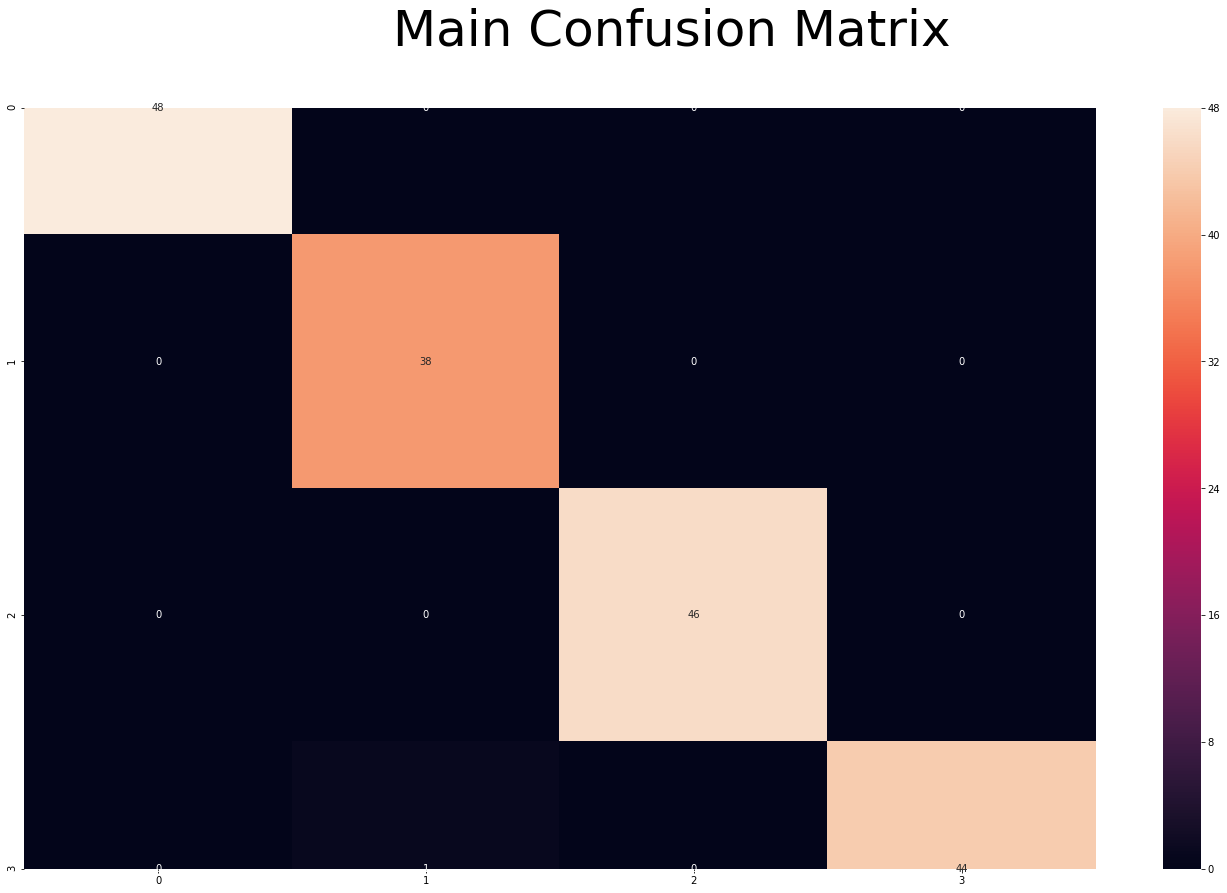

In [6]:
##Below method makes a prediction for the given test data:
predictions = model.predict(image_test)
predictions = np.argmax(predictions, axis=1)
calculateAccuracyMetrics(predictions,target_test)
plotConfusionMatrix(predictions,target_test,"Main")